In [30]:
import numpy as np
np.complex_ = np.complex128
np.float_ = np.float64
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px 
import plotly.io as pio
pio.renderers.default = 'iframe'
from IPython.display import display
from scipy.stats import norm
import math
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [31]:
def optimize_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Optimize memory usage of a DataFrame by changing the dtypes of its columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame to optimize.
    
    Returns:
    pd.DataFrame: The optimized DataFrame with reduced memory usage.
    """
    
    
    
    initial_memory = df.memory_usage(deep=True).sum() / 1024**2  # in MB
    
    print(f"Initial memory usage: {initial_memory:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            if pd.api.types.is_integer_dtype(col_type):
                c_min = df[col].min()
                c_max = df[col].max()
                
                if c_min >= 0:
                    if c_max < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_max < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_max < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif c_max < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            
            elif pd.api.types.is_float_dtype(col_type):
                df[col] = df[col].astype(np.float32)
                
        else:
            num_unique_values = df[col].nunique()
            num_total_values = len(df[col])
            
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
                
    final_memory = df.memory_usage(deep=True).sum() / 1024**2  # in MB
    print(f"Final memory usage: {final_memory:.2f} MB")
    print(f"Reduced by: {initial_memory - final_memory:.2f} MB ({100 * (initial_memory - final_memory) / initial_memory:.2f}%)")
    
    return df


def find_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    numeric_df = df.select_dtypes(include=[np.number])
    return numeric_df


def convert_datetime_columns(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        # Try to convert columns to datetime if they are not already
        if df[col].dtype == object:
            try:
                df[col] = pd.to_datetime(df[col], errors='raise')
            except (ValueError, TypeError):
                continue

    return df


def clean_and_convert_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:

    for col in df.select_dtypes(include=['category', 'object']).columns:
        print(col)
        df[col] = df[col].astype(str).str.strip()
        df = df[df[col].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
        df[col] = pd.to_numeric(df[col])

    return df


def contract_size_handler(contract_size):
    contract_size = contract_size.split(' x ')
    return contract_size[0] * contract_size[1]

In [32]:
df = pd.read_csv('../data/raw/qqq_2020_2022.csv',low_memory=False)
columns = df.columns
columns = [s.replace('[', '').replace(']', '').replace(' ', '').strip().lower() for s in columns]
df.columns = columns
df.sort_values('quote_date', inplace=True)
display(df.head())

,quote_unixtime,quote_readtime,quote_date,quote_time_hours,underlying_last,expire_date,expire_unix,dte,c_delta,c_gamma,...,p_last,p_delta,p_gamma,p_vega,p_theta,p_rho,p_iv,p_volume,strike_distance,strike_distance_pct
135981,1609794000,2021-01-04 16:00,2021-01-04,16.0,309.42,2021-09-30,1633032000,268.96,0.57007,0.00538,...,23.650000,-0.42754,0.00539,1.04095,-0.05359,-1.16852,0.271040,2.000000,5.4,0.018
135727,1609794000,2021-01-04 16:00,2021-01-04,16.0,309.42,2021-09-17,1631908800,255.96,1.00000,0.00000,...,1.220000,-0.00584,0.00010,0.04513,-0.00515,-0.01620,0.546800,0.000000,200.4,0.648
135728,1609794000,2021-01-04 16:00,2021-01-04,16.0,309.42,2021-09-17,1631908800,255.96,1.00000,0.00000,...,1.120000,-0.00699,0.00010,0.05331,-0.00547,-0.01954,0.559970,0.000000,199.4,0.644
135729,1609794000,2021-01-04 16:00,2021-01-04,16.0,309.42,2021-09-17,1631908800,255.96,1.00000,0.00000,...,1.490000,-0.00810,0.00016,0.05489,-0.00614,-0.01998,0.556780,0.000000,198.4,0.641
135730,1609794000,2021-01-04 16:00,2021-01-04,16.0,309.42,2021-09-17,1631908800,255.96,1.00000,0.00000,...,1.200000,-0.00763,0.00011,0.05662,-0.00601,-0.01996,0.555090,0.000000,197.4,0.638


In [59]:
df.columns

Index(['quote_unixtime', 'quote_readtime', 'quote_date', 'quote_time_hours',
       'underlying_last', 'expire_date', 'expire_unix', 'dte', 'c_delta',
       'c_gamma', 'c_vega', 'c_theta', 'c_rho', 'c_iv', 'c_volume', 'c_last',
       'c_size', 'c_bid', 'c_ask', 'strike', 'p_bid', 'p_ask', 'p_size',
       'p_last', 'p_delta', 'p_gamma', 'p_vega', 'p_theta', 'p_rho', 'p_iv',
       'p_volume', 'strike_distance', 'strike_distance_pct', 'itm',
       'cc_rate_bid', 'cc_rate_ask', 'cc_rate_last', 'moneyness',
       'moneyness_bin', 'dte_bin'],
      dtype='object')

In [33]:
def contract_size_handler(contract_size):
    contract_size = contract_size.split(' x ')
    return int(contract_size[0] )* int(contract_size[1] )
df['c_size'] = df['c_size'].apply(contract_size_handler)
df['p_size'] = df['p_size'].apply(contract_size_handler)

In [34]:
print(df)

         quote_unixtime     quote_readtime   quote_date  quote_time_hours  \
135981       1609794000   2021-01-04 16:00   2021-01-04              16.0   
135727       1609794000   2021-01-04 16:00   2021-01-04              16.0   
135728       1609794000   2021-01-04 16:00   2021-01-04              16.0   
135729       1609794000   2021-01-04 16:00   2021-01-04              16.0   
135730       1609794000   2021-01-04 16:00   2021-01-04              16.0   
...                 ...                ...          ...               ...   
1390089      1672434000   2022-12-30 16:00   2022-12-30              16.0   
1390090      1672434000   2022-12-30 16:00   2022-12-30              16.0   
1390091      1672434000   2022-12-30 16:00   2022-12-30              16.0   
1390093      1672434000   2022-12-30 16:00   2022-12-30              16.0   
1389898      1672434000   2022-12-30 16:00   2022-12-30              16.0   

         underlying_last  expire_date  expire_unix     dte  c_delta  c_gamm

In [35]:
for col in df.columns:
    if 'quote' in col or 'date' in col or 'unix' in col:
        continue
    df[col] = df[col].astype(str).str.strip()
    try:
        df[col][df[col].astype('str').str.strip() == '']=np.nan
        if df[col].str.contains('.').any():
          df[col] = df[col].astype(float)
    except:
        print(col)
df = convert_datetime_columns(df)

In [36]:
df = optimize_memory_usage(df)
display(df.head())

Initial memory usage: 460.63 MB
Final memory usage: 257.41 MB
Reduced by: 203.22 MB (44.12%)


,quote_unixtime,quote_readtime,quote_date,quote_time_hours,underlying_last,expire_date,expire_unix,dte,c_delta,c_gamma,...,p_last,p_delta,p_gamma,p_vega,p_theta,p_rho,p_iv,p_volume,strike_distance,strike_distance_pct
135981,1609794000,2021-01-04 16:00:00,2021-01-04,16.0,309.420013,2021-09-30,1633032000,268.959991,0.57007,0.00538,...,23.65,-0.42754,0.00539,1.04095,-0.05359,-1.16852,0.27104,2.0,5.400000,0.018
135727,1609794000,2021-01-04 16:00:00,2021-01-04,16.0,309.420013,2021-09-17,1631908800,255.960007,1.00000,0.00000,...,1.22,-0.00584,0.00010,0.04513,-0.00515,-0.01620,0.54680,0.0,200.399994,0.648
135728,1609794000,2021-01-04 16:00:00,2021-01-04,16.0,309.420013,2021-09-17,1631908800,255.960007,1.00000,0.00000,...,1.12,-0.00699,0.00010,0.05331,-0.00547,-0.01954,0.55997,0.0,199.399994,0.644
135729,1609794000,2021-01-04 16:00:00,2021-01-04,16.0,309.420013,2021-09-17,1631908800,255.960007,1.00000,0.00000,...,1.49,-0.00810,0.00016,0.05489,-0.00614,-0.01998,0.55678,0.0,198.399994,0.641
135730,1609794000,2021-01-04 16:00:00,2021-01-04,16.0,309.420013,2021-09-17,1631908800,255.960007,1.00000,0.00000,...,1.20,-0.00763,0.00011,0.05662,-0.00601,-0.01996,0.55509,0.0,197.399994,0.638


In [37]:
df.isnull().sum()


quote_unixtime              0
quote_readtime              0
quote_date                  0
quote_time_hours            0
underlying_last             0
expire_date                 0
expire_unix                 0
dte                         0
c_delta                     0
c_gamma                     0
c_vega                      0
c_theta                     0
c_rho                       0
c_iv                    93606
c_volume               428188
c_last                   1028
c_size                      0
c_bid                    1028
c_ask                    1028
strike                      0
p_bid                    1028
p_ask                    1028
p_size                      0
p_last                   1028
p_delta                     0
p_gamma                     0
p_vega                      0
p_theta                     0
p_rho                       0
p_iv                   123460
p_volume               441437
strike_distance             0
strike_distance_pct         0
dtype: int

In [38]:
both_c_iv_and_c_volume_nan = (df['c_iv'].isnull() & df['c_volume'].isnull()).sum()
both_p_iv_and_p_volume_nan = (df['p_iv'].isnull() & df['p_volume'].isnull()).sum()

print(f"Number of rows where both c_iv and c_volume are NaN: {both_c_iv_and_c_volume_nan}")
print(f"Number of rows where both p_iv and p_volume are NaN: {both_p_iv_and_p_volume_nan}")

Number of rows where both c_iv and c_volume are NaN: 49752
Number of rows where both p_iv and p_volume are NaN: 65217


In [39]:
df = df.fillna(0)

In [40]:
df.iloc[0]

quote_unixtime                  1609794000
quote_readtime         2021-01-04 16:00:00
quote_date             2021-01-04 00:00:00
quote_time_hours                      16.0
underlying_last                 309.420013
expire_date            2021-09-30 00:00:00
expire_unix                     1633032000
dte                             268.959991
c_delta                            0.57007
c_gamma                            0.00538
c_vega                             1.04036
c_theta                           -0.05082
c_rho                                0.998
c_iv                               0.27253
c_volume                               1.0
c_last                           32.869999
c_size                              3250.0
c_bid                            30.620001
c_ask                            31.059999
strike                               304.0
p_bid                            25.700001
p_ask                                26.76
p_size                               209.0
p_last     

In [41]:
df.iloc[1]


quote_unixtime                  1609794000
quote_readtime         2021-01-04 16:00:00
quote_date             2021-01-04 00:00:00
quote_time_hours                      16.0
underlying_last                 309.420013
expire_date            2021-09-17 00:00:00
expire_unix                     1631908800
dte                             255.960007
c_delta                                1.0
c_gamma                                0.0
c_vega                                 0.0
c_theta                                0.0
c_rho                                  0.0
c_iv                                   0.0
c_volume                               0.0
c_last                                 0.0
c_size                                10.0
c_bid                           199.080002
c_ask                           201.320007
strike                               109.0
p_bid                                 0.11
p_ask                                 0.54
p_size                               120.0
p_last     

In [42]:
df.columns

Index(['quote_unixtime', 'quote_readtime', 'quote_date', 'quote_time_hours',
       'underlying_last', 'expire_date', 'expire_unix', 'dte', 'c_delta',
       'c_gamma', 'c_vega', 'c_theta', 'c_rho', 'c_iv', 'c_volume', 'c_last',
       'c_size', 'c_bid', 'c_ask', 'strike', 'p_bid', 'p_ask', 'p_size',
       'p_last', 'p_delta', 'p_gamma', 'p_vega', 'p_theta', 'p_rho', 'p_iv',
       'p_volume', 'strike_distance', 'strike_distance_pct'],
      dtype='object')

In [63]:
df['p_iv']

135981     0.27104
135727     0.54680
135728     0.55997
135729     0.55678
135730     0.55509
            ...   
1390089    0.31966
1390090    0.31788
1390091    0.31499
1390093    0.31070
1389898    0.29073
Name: p_iv, Length: 1775749, dtype: float32

In [71]:
# Count conditions
count_le_0 = (df['p_iv'] < 0).sum()       # strictly less than 0
count_eq_0 = (df['p_iv'] == 0).sum()      # exactly equal to 0
count_gt_3 = (df['p_iv'] > 3).sum()       # strictly greater than 3
count = (df['p_iv']).sum() - count_le_0 - count_eq_0 - count_gt_3

print("<= 0:", count_le_0 + count_eq_0)   # if you want combined <= 0
print("= 0 :", count_eq_0)
print("> 3 :", count_gt_3)
print("Rest :", count)

<= 0: 131191
= 0 : 123829
> 3 : 3379
Rest : 460581.125


In [68]:
from scipy import optimize
import scipy.stats as si

def calc_implied_vol(S, K, T, r, market_price, option_type="call"):
    if T <= 0 or market_price <= 0:
        return np.nan

    def bs_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == "call":
            return S * si.norm.cdf(d1) - K * np.exp(-r*T) * si.norm.cdf(d2) - market_price
        else:
            return K * np.exp(-r*T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1) - market_price

    try:
        return optimize.brentq(bs_price, 1e-6, 5.0, maxiter=500)
    except ValueError:
        try:
            # fallback with wider bounds
            return optimize.brentq(bs_price, 1e-6, 50.0, maxiter=500)
        except:
            return np.nan


# ------------------------------
# ⚡ Apply to your DataFrame
# ------------------------------

rf_rate = 0.0234  # risk-free rate (you can update if needed)

# Only compute for rows with valid data
df['c_iv_calc'] = df.apply(
    lambda row: calc_implied_vol(
        row['underlying_last'], 
        row['strike'], 
        row['dte']/365, 
        rf_rate, 
        row['c_last'], 
        option_type="call"
    ) if row['c_last'] > 0 and row['dte'] > 0 else np.nan,
    axis=1
)

df['p_iv_calc'] = df.apply(
    lambda row: calc_implied_vol(
        row['underlying_last'], 
        row['strike'], 
        row['dte']/365, 
        rf_rate, 
        row['p_last'], 
        option_type="put"
    ) if row['p_last'] > 0 and row['dte'] > 0 else np.nan,
    axis=1
)

print(df[['c_iv', 'c_iv_calc', 'p_iv', 'p_iv_calc']].head(10))


           c_iv  c_iv_calc     p_iv  p_iv_calc
135981  0.27253   0.262066  0.27104   0.275727
135727  0.52515        NaN  0.54680   0.679137
135728  0.52515        NaN  0.55997   0.663817
135729  0.52515        NaN  0.55678   0.692655
135730  0.52515        NaN  0.55509   0.661078
135731  0.52515        NaN  0.55229   0.654855
135732  0.52515        NaN  0.55096   0.652471
135733  0.52515        NaN  0.54879   0.695196
135734  0.52515        NaN  0.54603        NaN
135726  0.52515        NaN  0.56401        NaN


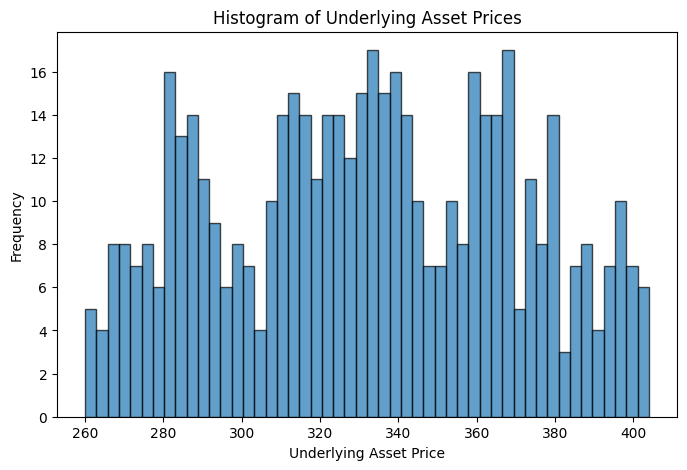

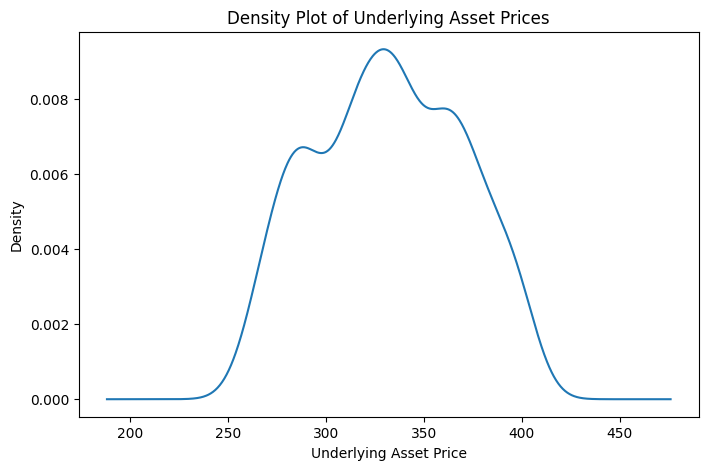

In [43]:

underlying_prices = df.groupby('quote_date')['underlying_last'].agg('last')

plt.figure(figsize=(8,5))
plt.hist(underlying_prices, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of Underlying Asset Prices')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Frequency')
plt.show()

# Density plot (KDE)
underlying_prices.plot(kind='kde', figsize=(8,5))
plt.title('Density Plot of Underlying Asset Prices')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Density')
plt.show()


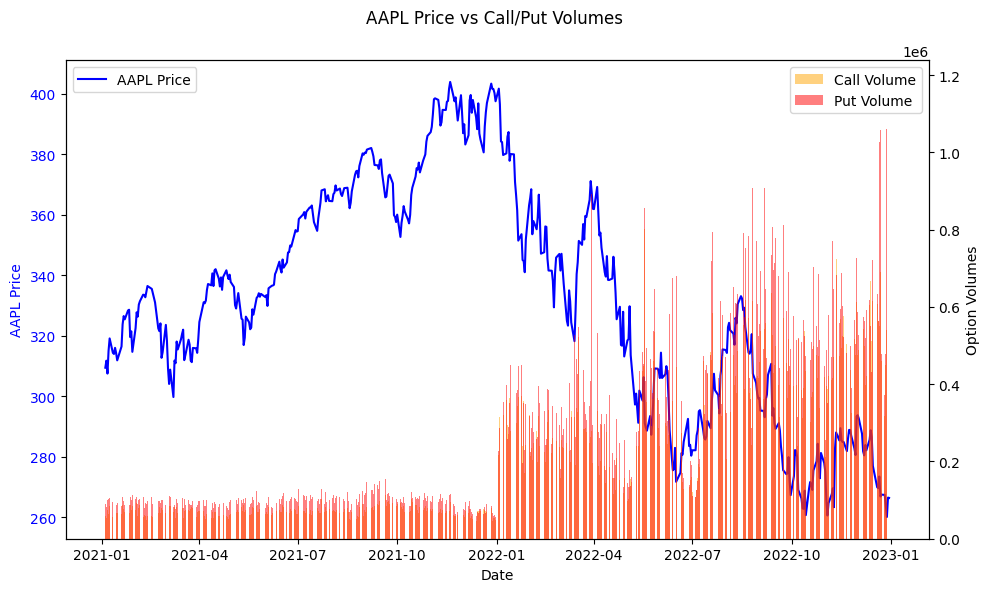

In [44]:

underlying_prices = df.groupby('quote_date')['underlying_last'].agg('last')
call_put_volumes = df.groupby('quote_date')[['c_volume','p_volume']].sum().reset_index()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot line for underlying price
ax1.plot(underlying_prices.index, underlying_prices, color='blue', label='AAPL Price')
ax1.set_xlabel("Date")
ax1.set_ylabel("AAPL Price", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for volumes
ax2 = ax1.twinx()
ax2.bar(call_put_volumes['quote_date'], call_put_volumes['c_volume'], 
        color='orange', alpha=0.5, label='Call Volume')
ax2.bar(call_put_volumes['quote_date'], call_put_volumes['p_volume'], 
        color='red', alpha=0.5, label='Put Volume')
ax2.set_ylabel("Option Volumes", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title & legends
fig.suptitle("AAPL Price vs Call/Put Volumes")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


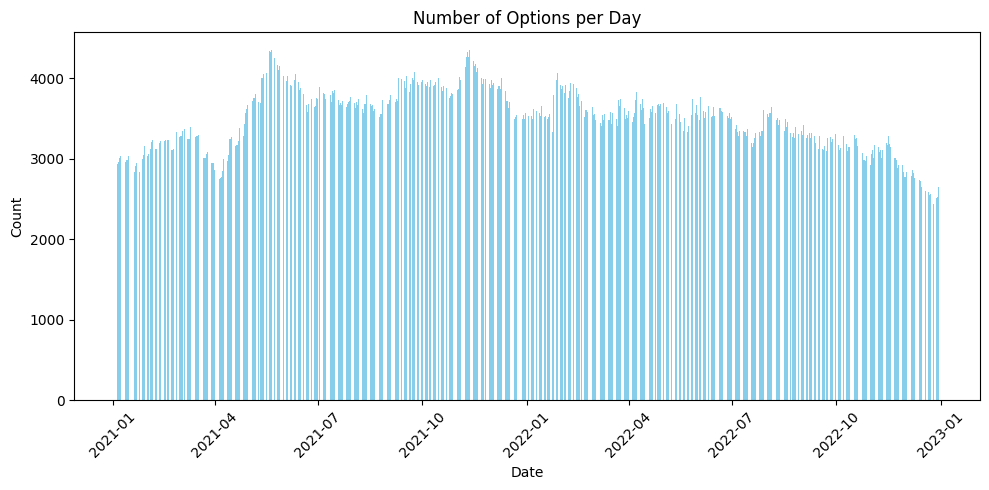

In [45]:

daily_counts = df.groupby('quote_date').size().reset_index(name='count')

# Plot
plt.figure(figsize=(10,5))
plt.bar(daily_counts['quote_date'], daily_counts['count'], color='skyblue')
plt.title("Number of Options per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [46]:
df['strike_distance'] = df['underlying_last'] - df['strike']
df['strike_distance_pct'] =  df['strike_distance'] / df['underlying_last'] 
df['itm'] = 1 - df['strike']/df['underlying_last']
df['cc_rate_bid'] = (df['strike'] / (df['underlying_last'] - df['c_bid']) ) ** (365 / df['dte']) - 1
df['cc_rate_ask'] = (df['strike'] / (df['underlying_last'] - df['c_ask']) ) ** (365 / df['dte']) - 1
df['cc_rate_last'] = (df['strike'] / (df['underlying_last'] - df['c_last']) ) ** (365 / df['dte']) - 1

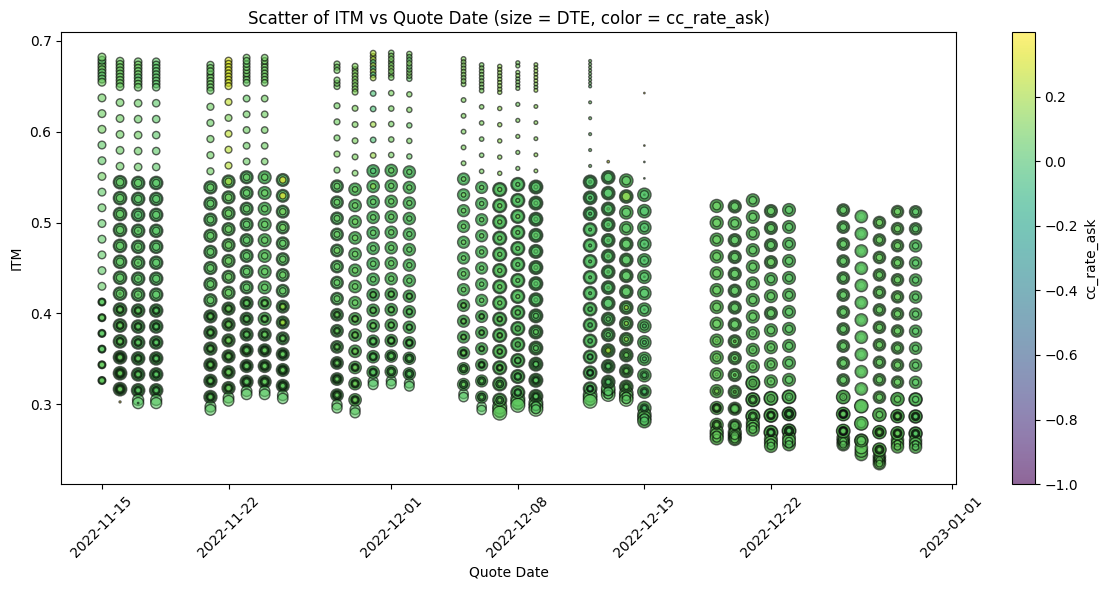

In [47]:

df_filtered = df.iloc[-90000:][
    (df['strike'] > 70) &
    (df['dte'] < 100) &
    (df['strike'] < 200) &
    (df['cc_rate_ask'] < 0.4)
]

# Scatter plot
plt.figure(figsize=(12,6))
scatter = plt.scatter(
    df_filtered['quote_date'],
    df_filtered['itm'],
    s=df_filtered['dte'],          # size mapped to dte
    c=df_filtered['cc_rate_ask'],  # color mapped to cc_rate_ask
    cmap='viridis',
    alpha=0.6,
    edgecolor='k'
)

plt.title("Scatter of ITM vs Quote Date (size = DTE, color = cc_rate_ask)")
plt.xlabel("Quote Date")
plt.ylabel("ITM")
plt.xticks(rotation=45)

# Add colorbar for cc_rate_ask
cbar = plt.colorbar(scatter)
cbar.set_label("cc_rate_ask")

plt.tight_layout()
plt.show()


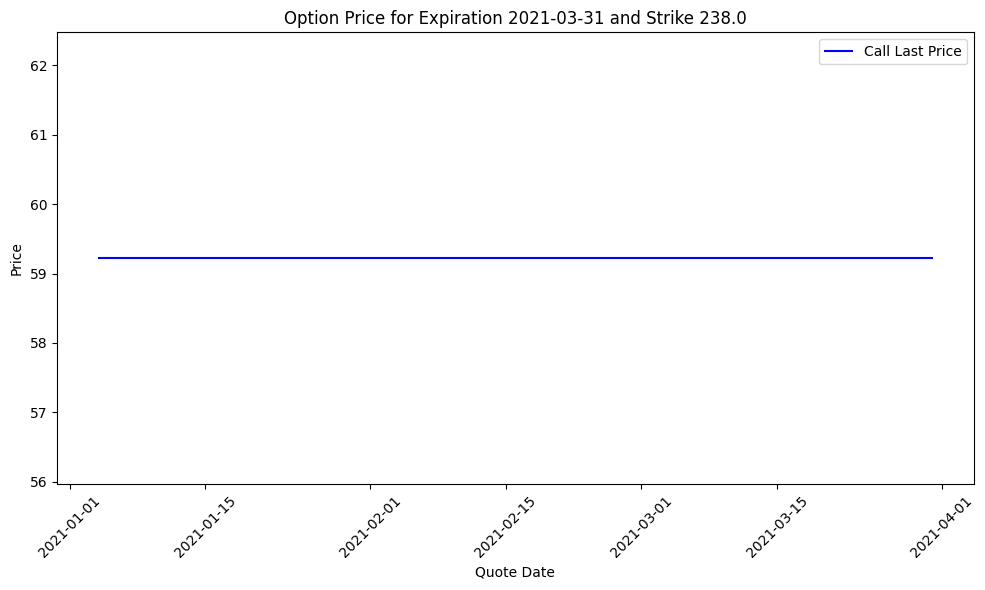

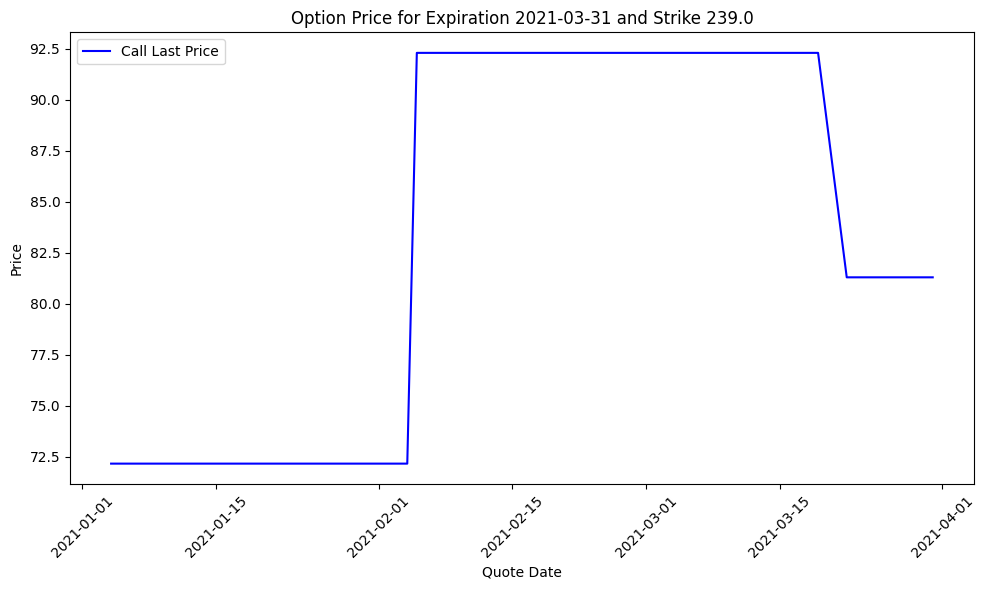

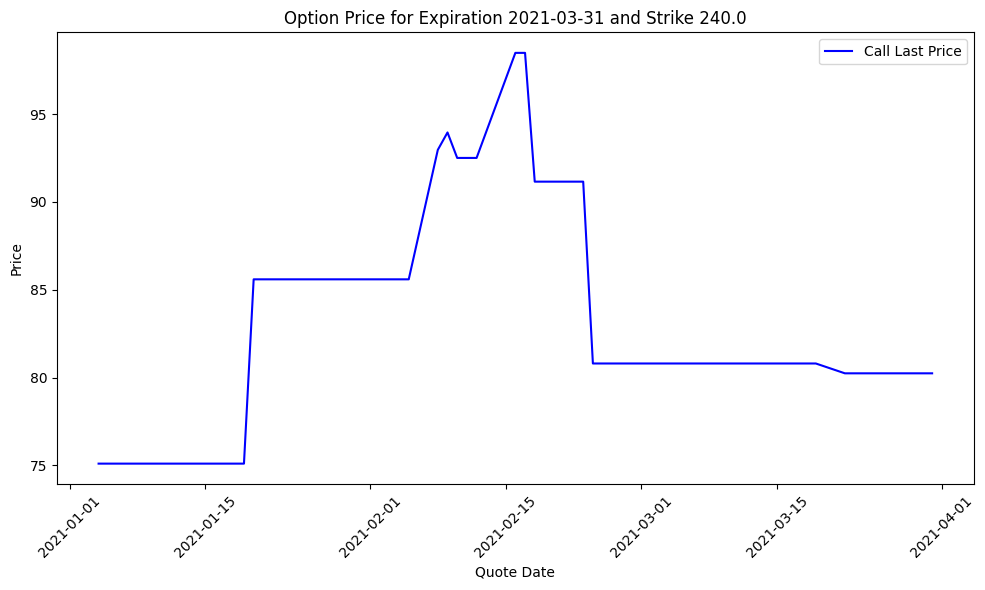

In [48]:

grouped = df.groupby(['expire_date', 'strike'])

count = 0
for (expiration, strike), group in grouped:
    if count < 2000:
        count += 1
        continue
    
    plt.figure(figsize=(10,6))
    plt.plot(group['quote_date'], group['c_last'], label='Call Last Price', color='blue')

    plt.title(f"Option Price for Expiration {expiration.date()} and Strike {strike}")
    plt.xlabel("Quote Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    count += 1
    if count == 2003:   # stop after 3 plots
        break


In [49]:
df[(df['itm'] > .2) & (df['cc_rate_ask'] > .1) &( df['c_volume']>10) &(df['dte'] > 20) &(df['cc_rate_last'] <0.5)].sort_values('cc_rate_ask',ascending=False).tail(10)

,quote_unixtime,quote_readtime,quote_date,quote_time_hours,underlying_last,expire_date,expire_unix,dte,c_delta,c_gamma,...,p_theta,p_rho,p_iv,p_volume,strike_distance,strike_distance_pct,itm,cc_rate_bid,cc_rate_ask,cc_rate_last
131323,1614373200,2021-02-26 16:00:00,2021-02-26,16.0,314.510010,2021-03-31,1617220800,32.959999,0.89531,0.00024,...,-0.01289,-0.00089,0.70908,5.0,131.510010,0.418143,0.418142,0.049075,0.117727,-0.340119
121468,1614114000,2021-02-23 16:00:00,2021-02-23,16.0,321.519989,2021-03-19,1616184000,23.959999,0.84808,0.00000,...,-0.00136,0.00000,1.40594,20.0,229.519989,0.713859,0.713859,0.038870,0.115920,-0.817817
742814,1627588800,2021-07-29 16:00:00,2021-07-29,16.0,366.489990,2021-08-20,1629489600,22.000000,0.87648,0.00002,...,-0.00134,-0.00017,0.93801,10.0,201.489990,0.549783,0.549783,-0.049913,0.111729,-0.882384
187956,1611954000,2021-01-29 16:00:00,2021-01-29,16.0,314.679993,2021-03-31,1617220800,60.959999,0.88398,0.00182,...,-0.06609,-0.03766,0.49882,25.0,79.679993,0.253210,0.253210,0.074408,0.111428,-0.147341
552337,1639774800,2021-12-17 16:00:00,2021-12-17,16.0,384.959991,2022-01-21,1642798800,35.000000,0.97909,0.00043,...,-0.01154,-0.00184,0.66506,0.0,159.959991,0.415524,0.415524,-0.019261,0.109980,0.151877
187963,1611954000,2021-01-29 16:00:00,2021-01-29,16.0,314.679993,2021-03-31,1617220800,60.959999,0.87478,0.00223,...,-0.07271,-0.04495,0.47666,20.0,72.679993,0.230965,0.230965,0.096366,0.108007,-0.058068
318031,1637096400,2021-11-16 16:00:00,2021-11-16,16.0,397.429993,2022-01-21,1642798800,66.000000,0.84643,-0.00003,...,-0.00138,0.00000,0.91015,6.0,287.429993,0.723222,0.723222,-0.009001,0.107939,-0.668945
1032512,1666641600,2022-10-24 16:00:00,2022-10-24,16.0,278.500000,2023-03-17,1679083200,144.000000,0.87708,0.00303,...,-0.04644,-0.15730,0.39880,138.0,58.500000,0.210054,0.210054,0.098832,0.104635,0.098701
23574,1615410000,2021-03-10 16:00:00,2021-03-10,16.0,310.920013,2021-03-31,1617220800,20.959999,1.00000,0.00000,...,-0.00166,0.00000,1.46657,30.0,218.920013,0.704104,0.704104,-0.112056,0.103740,-0.046160
494538,1619640000,2021-04-28 16:00:00,2021-04-28,16.0,338.750000,2021-06-18,1624046400,51.000000,1.00000,0.00000,...,-0.00283,-0.00061,0.71015,0.0,183.750000,0.542435,0.542435,-0.096359,0.100489,-0.698513


In [50]:
sub_df = df.groupby(['expire_date','strike'])[['cc_rate_bid' , 'cc_rate_ask' ,'cc_rate_last', 'itm','underlying_last']].agg({'cc_rate_bid': 'mean', 
                                                                                                           'cc_rate_ask' : 'mean','cc_rate_last' : 'mean',
                                                                                                           'itm' : 'median' , 'underlying_last':'mean'}).reset_index()

In [51]:
sub_df

,expire_date,strike,cc_rate_bid,cc_rate_ask,cc_rate_last,itm,underlying_last
0,2021-01-08,160.0,-0.146112,inf,-1.000000,0.486768,312.556000
1,2021-01-08,165.0,-0.142541,inf,-0.426609,0.470730,312.556000
2,2021-01-08,170.0,-0.144289,inf,-1.000000,0.454691,312.556000
3,2021-01-08,175.0,-0.506749,inf,-1.000000,0.438653,312.556000
4,2021-01-08,180.0,-0.511584,inf,52.521370,0.422614,312.556000
...,...,...,...,...,...,...,...
41457,2025-01-17,435.0,0.239559,0.247907,0.243508,-0.554682,278.103302
41458,2025-01-17,440.0,0.246083,0.253097,0.248651,-0.572552,278.103302
41459,2025-01-17,445.0,0.251783,0.257698,0.256242,-0.590422,278.103302
41460,2025-01-17,450.0,0.257842,0.263558,0.260411,-0.608292,278.103302


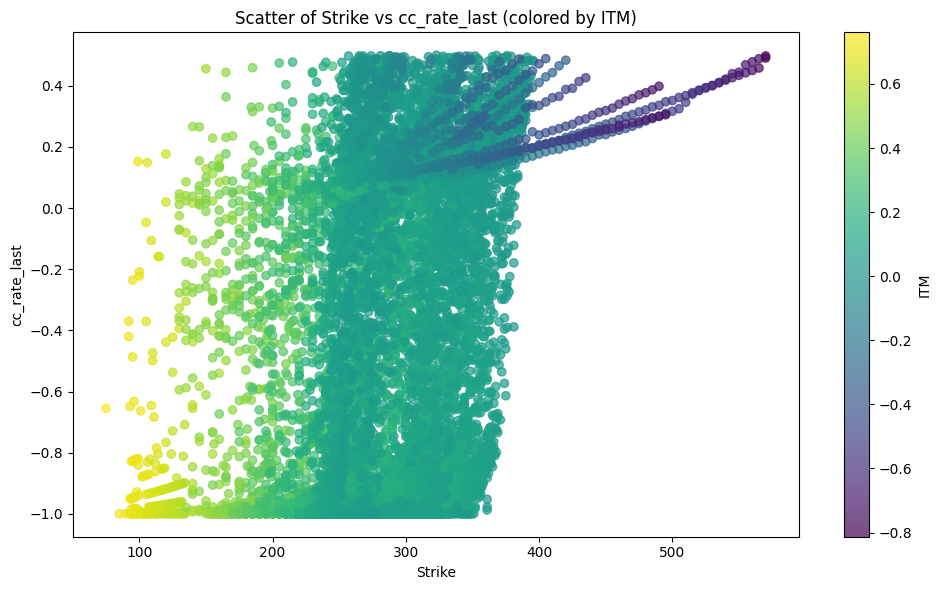

In [52]:
filtered = sub_df[sub_df['cc_rate_last'] < 0.5]

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    filtered['strike'], 
    filtered['cc_rate_last'], 
    c=filtered['itm'], 
    cmap='viridis', 
    alpha=0.7
)

plt.title("Scatter of Strike vs cc_rate_last (colored by ITM)")
plt.xlabel("Strike")
plt.ylabel("cc_rate_last")
plt.colorbar(scatter, label="ITM")
plt.tight_layout()
plt.show()

In [53]:

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the Black-Scholes price for a European call or put option.

    Parameters:
    S : float : Stock price
    K : float : Strike price
    T : float : Time to maturity (in years)
    r : float : Risk-free interest rate (annual rate)
    sigma : float : Volatility of the underlying stock (annual standard deviation)
    option_type : str : 'call' or 'put'

    Returns:
    price : float : Price of the option
    """
    try:
        d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
        d2 = d1 - sigma * math.sqrt(T)
    except: return np.nan
    if option_type == 'call':
        try:
            price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
        except: price=np.nan
    elif option_type == 'put':
        try:
            price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        except:price=np.nan
    return price

In [54]:
NUM_EPOCHS = 50 
BATCH_SIZE = 256

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# call_df = df[df['c_volume'] > 0].copy()


# New Code added 
df['c_iv'] = df['c_iv'].replace(0, np.nan)
df.loc[(df['c_iv'] <= 0) | (df['c_iv'] > 3.0), 'c_iv'] = np.nan

df['moneyness'] = df['strike'] / df['underlying_last']
df['moneyness_bin'] = pd.cut(df['moneyness'], bins=[0,0.8,0.9,1.0,1.1,1.2,10], include_lowest=True)
df['dte_bin'] = pd.cut(df['dte'], bins=[0,7,30,60,90,180,365,10000], include_lowest=True)

iv_med_exp_moneyness = df.groupby(['expire_date','moneyness_bin'])['c_iv'].transform('median')
df['c_iv'] = df['c_iv'].fillna(iv_med_exp_moneyness)

iv_med_dte_moneyness = df.groupby(['dte_bin','moneyness_bin'])['c_iv'].transform('median')
df['c_iv'] = df['c_iv'].fillna(iv_med_dte_moneyness)

df['c_iv'] = df['c_iv'].fillna(df['c_iv'].median())
df['c_iv'] = df['c_iv'].clip(lower=0.02, upper=2.0)

# Keep only call rows with valid IV
call_df = df[(df['c_volume'] > 0) & np.isfinite(df['c_iv'])].copy()
#New code added end



# Define input features and target variable
input_features = ['underlying_last', 'dte', 'strike', 'c_rho', 'c_vega','c_iv'] 
target = 'c_last'



len_call_df = len(call_df)
call_train = call_df[:int(len_call_df*0.8)]
call_test = call_df[int(len_call_df*0.8):]


len_call_df_train = len(call_train)
call_train_final = call_train[:int(len_call_df_train*0.8)]
call_validate =call_train[int(len_call_df_train*0.8):]


scaler_x = MinMaxScaler()  
scaler_y = MinMaxScaler()  

X_train = scaler_x.fit_transform(call_train_final[input_features]) 
y_train = scaler_y.fit_transform(call_train_final[[target]])  
X_val = scaler_x.transform(call_validate[input_features])
y_val = scaler_y.transform(call_validate[[target]]) 
X_test = scaler_x.transform(call_test[input_features])  
y_test = scaler_y.transform(call_test[[target]])

# Reshape data for LSTM input [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1])) 
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  

print(f"call_train_final: {len(call_train_final)} rows (64% of total)") 
print(f"call_validate: {len(call_validate)} rows (16% of total)")  
print(f"call_test: {len(call_test)} rows (20% of total)")
print()
print(f"X_train shape: {X_train.shape}") 
print(f"X_val shape: {X_val.shape}")  
print(f"X_test shape: {X_test.shape}") 
print()
print(f"y_train shape: {y_train.shape}")  
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}") 

call_train_final: 520271 rows (64% of total)
call_validate: 130068 rows (16% of total)
call_test: 162585 rows (20% of total)

X_train shape: (520271, 1, 6)
X_val shape: (130068, 1, 6)
X_test shape: (162585, 1, 6)

y_train shape: (520271, 1)
y_val shape: (130068, 1)
y_test shape: (162585, 1)


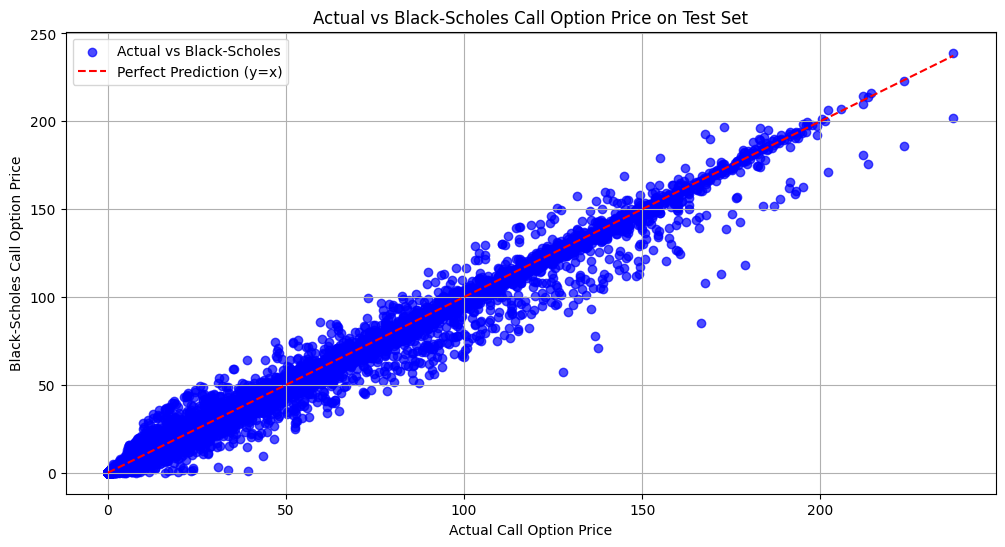

Mean Squared Error (MSE) between actual and BS call price: 3.1478
Mean Absolute Error (MAE) between actual and BS call price: 0.6492
Root Mean Squared Error (RMSE) between actual and BS call price: 1.7742


In [56]:
rf_rate= .0234
call_test['bs_call_price'] = call_test.apply(
    lambda row: black_scholes(
        S=row['underlying_last'], 
        K=row['strike'], 
        T=row['dte'] / 365, 
        r=rf_rate, 
        sigma=row['c_iv'] , 
        option_type='call'
    ), 
    axis=1
)

### Call
plt.figure(figsize=(12, 6))
plt.scatter(call_test['c_last'], call_test['bs_call_price'], alpha=0.7, color='blue', label='Actual vs Black-Scholes')
plt.plot([min(call_test['c_last']), max(call_test['c_last'])], [min(call_test['c_last']), max(call_test['c_last'])], 'r--', label='Perfect Prediction (y=x)'
)
plt.title('Actual vs Black-Scholes Call Option Price on Test Set')
plt.xlabel('Actual Call Option Price')
plt.ylabel('Black-Scholes Call Option Price')
plt.legend()
plt.grid(True)
plt.show()


def calculate_errors(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(mse)
    return mse, mae, rmse

bsm_mse_call, bsm_mae_call, bsm_rmse_call = calculate_errors(call_test['c_last'], call_test['bs_call_price'])

print(f"Mean Squared Error (MSE) between actual and BS call price: {bsm_mse_call:.4f}")
print(f"Mean Absolute Error (MAE) between actual and BS call price: {bsm_mae_call:.4f}")
print(f"Root Mean Squared Error (RMSE) between actual and BS call price: {bsm_rmse_call:.4f}")

Epoch 1/50
2032/2033 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038Epoch 1:
  Train MSE: 47.8208, MAE: 3.8984, RMSE: 6.9153
  Val MSE: 293272.3125, MAE: 4.7618, RMSE: 541.5462
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 52s 25ms/step - loss: 0.0038 - val_loss: 3.0891
Epoch 2/50
2028/2033 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1305e-04Epoch 2:
  Train MSE: 47.3095, MAE: 3.9017, RMSE: 6.8782
  Val MSE: 293827.0938, MAE: 4.4052, RMSE: 542.0582
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 52s 25ms/step - loss: 5.1305e-04 - val_loss: 3.0949
Epoch 3/50
2032/2033 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0769e-04Epoch 3:
  Train MSE: 47.0358, MAE: 3.8260, RMSE: 6.8583
  Val MSE: 194569.7656, MAE: 4.1875, RMSE: 441.1006
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - loss: 5.0770e-04 - val_loss: 2.0494
Epoch 4/50
2030/2033 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0401e-04Epoch 4:
  Train MSE: 52.1363, MAE: 4.3969, RMSE: 7.2205
  Val MSE: 62955.7070, MAE: 4.0631, RMSE: 250.9098
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 5

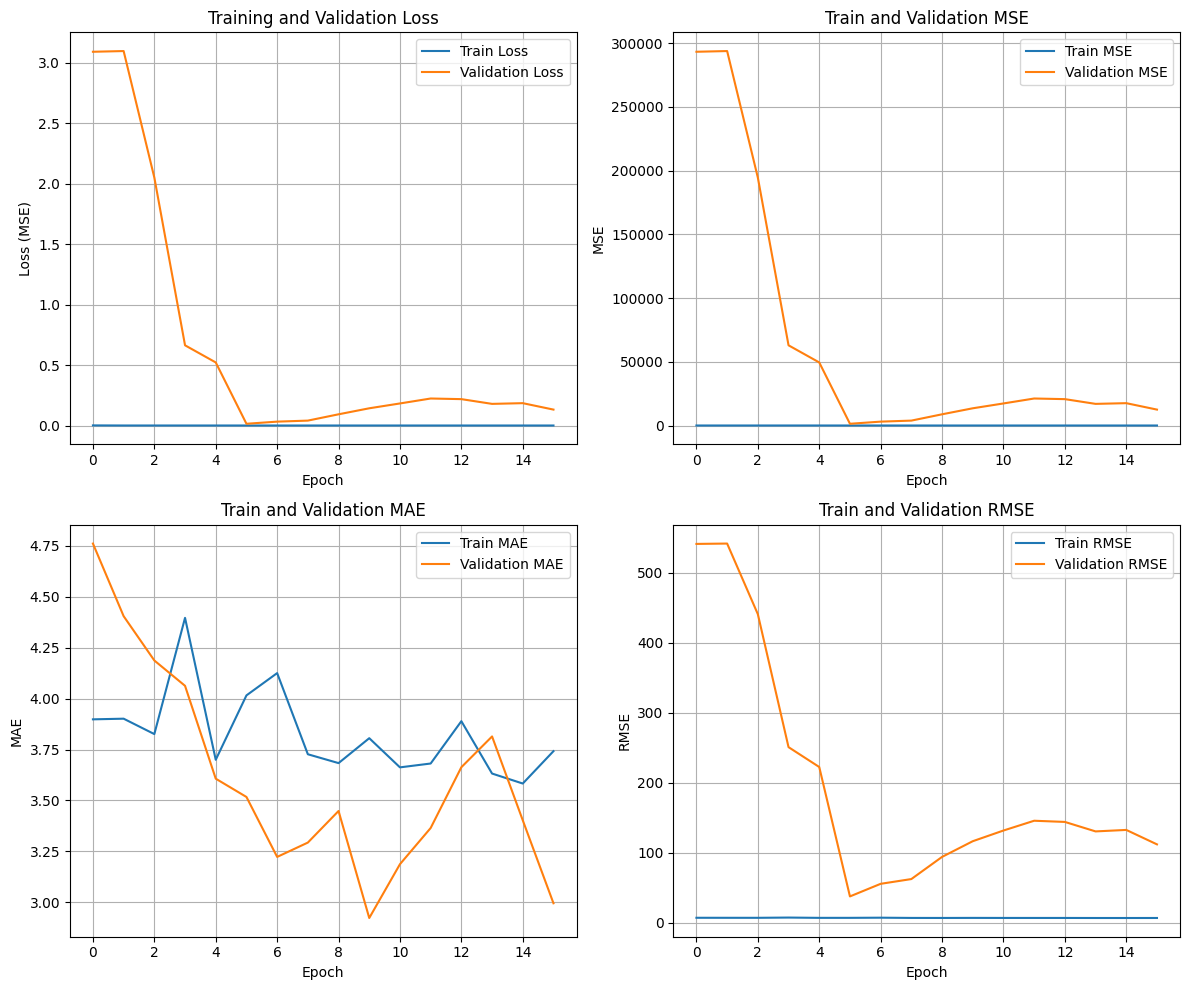

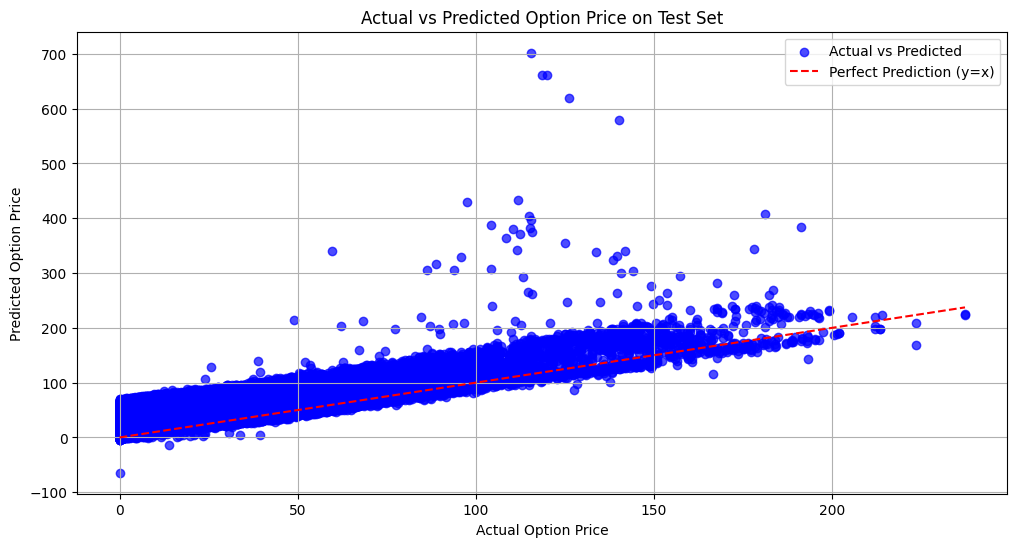

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Custom callback to track metrics
class MetricsCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, scaler_y):
        super(MetricsCallback, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scaler_y = scaler_y
        self.train_mse = []
        self.train_mae = []
        self.train_rmse = []
        self.val_mse = []
        self.val_mae = []
        self.val_rmse = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        y_val_pred = self.model.predict(self.X_val, verbose=0)

        y_train_true = self.scaler_y.inverse_transform(self.y_train)
        y_train_pred = self.scaler_y.inverse_transform(y_train_pred)
        y_val_true = self.scaler_y.inverse_transform(self.y_val)
        y_val_pred = self.scaler_y.inverse_transform(y_val_pred)

        train_mse = mean_squared_error(y_train_true, y_train_pred)
        train_mae = mean_absolute_error(y_train_true, y_train_pred)
        train_rmse = np.sqrt(train_mse)

        val_mse = mean_squared_error(y_val_true, y_val_pred)
        val_mae = mean_absolute_error(y_val_true, y_val_pred)
        val_rmse = np.sqrt(val_mse)

        self.train_mse.append(train_mse)
        self.train_mae.append(train_mae)
        self.train_rmse.append(train_rmse)
        self.val_mse.append(val_mse)
        self.val_mae.append(val_mae)
        self.val_rmse.append(val_rmse)

        print(f'Epoch {epoch+1}:')
        print(f'  Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}')
        print(f'  Val MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}')

# Build LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(1))

# Compile with RMSE loss
model.compile(optimizer='adam', loss='mse')  # Using MSE as loss, since RMSE is sqrt(MSE)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
metrics_callback = MetricsCallback(X_train, y_train, X_val, y_val, scaler_y)

# Train model
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val), callbacks=[early_stop, metrics_callback], verbose=1)

# Evaluate on test set
y_pred = model.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

lstm_mse_call = mean_squared_error(y_test_inv, y_pred_inv)
lstm_mae_call = mean_absolute_error(y_test_inv, y_pred_inv)
lstm_rmse_call = np.sqrt(lstm_mse_call)

print(f'MSE on test set: {lstm_mse_call:.4f}')
print(f'MAE on test set: {lstm_mae_call:.4f}')
print(f'RMSE on test set: {lstm_rmse_call:.4f}')

# Save model weights
model.save_weights('lstm_call_price_model.weights.h5')

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1: Training and Validation Loss
axs[0, 0].plot(history.history['loss'], label='Train Loss')
axs[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Training and Validation Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss (MSE)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Subplot 2: MSE over Epochs
axs[0, 1].plot(metrics_callback.train_mse, label='Train MSE')
axs[0, 1].plot(metrics_callback.val_mse, label='Validation MSE')
axs[0, 1].set_title('Train and Validation MSE')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Subplot 3: MAE over Epochs
axs[1, 0].plot(metrics_callback.train_mae, label='Train MAE')
axs[1, 0].plot(metrics_callback.val_mae, label='Validation MAE')
axs[1, 0].set_title('Train and Validation MAE')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Subplot 4: RMSE over Epochs
axs[1, 1].plot(metrics_callback.train_rmse, label='Train RMSE')
axs[1, 1].plot(metrics_callback.val_rmse, label='Validation RMSE')
axs[1, 1].set_title('Train and Validation RMSE')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('RMSE')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.7, color='blue', label='Actual vs Predicted')
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--', label='Perfect Prediction (y=x)')
plt.title('Actual vs Predicted Option Price on Test Set')
plt.xlabel('Actual Option Price')
plt.ylabel('Predicted Option Price')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50
2032/2033 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029Epoch 1:
  Train MSE: 47.7638, MAE: 3.8559, RMSE: 6.9111
  Val MSE: 15582.4883, MAE: 3.0748, RMSE: 124.8298
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - loss: 0.0029 - val_loss: 0.1641
Epoch 2/50
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1420e-04Epoch 2:
  Train MSE: 46.6011, MAE: 3.7819, RMSE: 6.8265
  Val MSE: 11487.6191, MAE: 3.3698, RMSE: 107.1803
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - loss: 5.1420e-04 - val_loss: 0.1210
Epoch 3/50
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0407e-04Epoch 3:
  Train MSE: 47.5674, MAE: 3.8476, RMSE: 6.8969
  Val MSE: 4363.1099, MAE: 3.3683, RMSE: 66.0538
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 5.0407e-04 - val_loss: 0.0460
Epoch 4/50
2032/2033 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0169e-04Epoch 4:
  Train MSE: 47.9663, MAE: 3.9760, RMSE: 6.9258
  Val MSE: 4118.5767, MAE: 3.5385, RMSE: 64.1761
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/ste

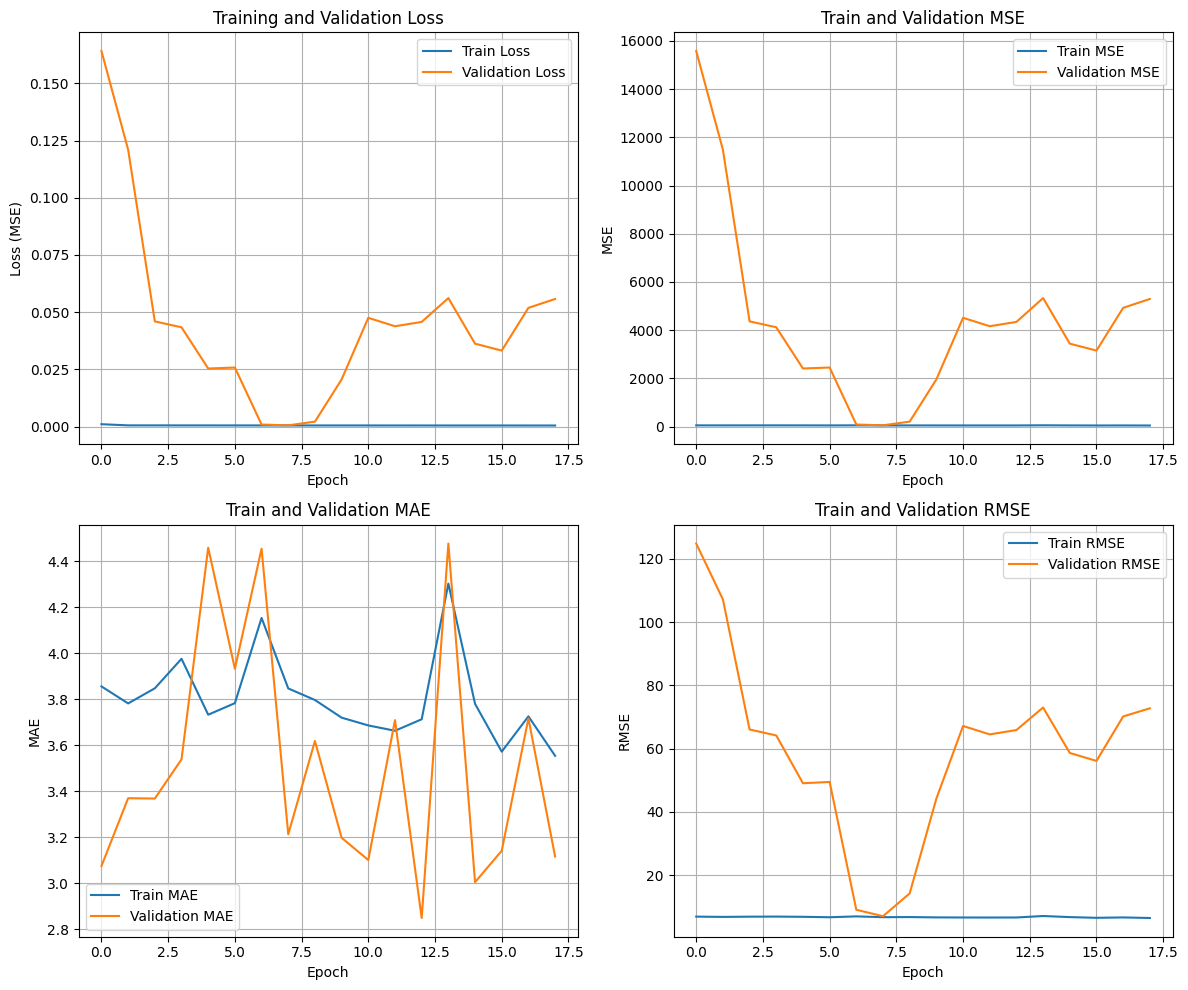

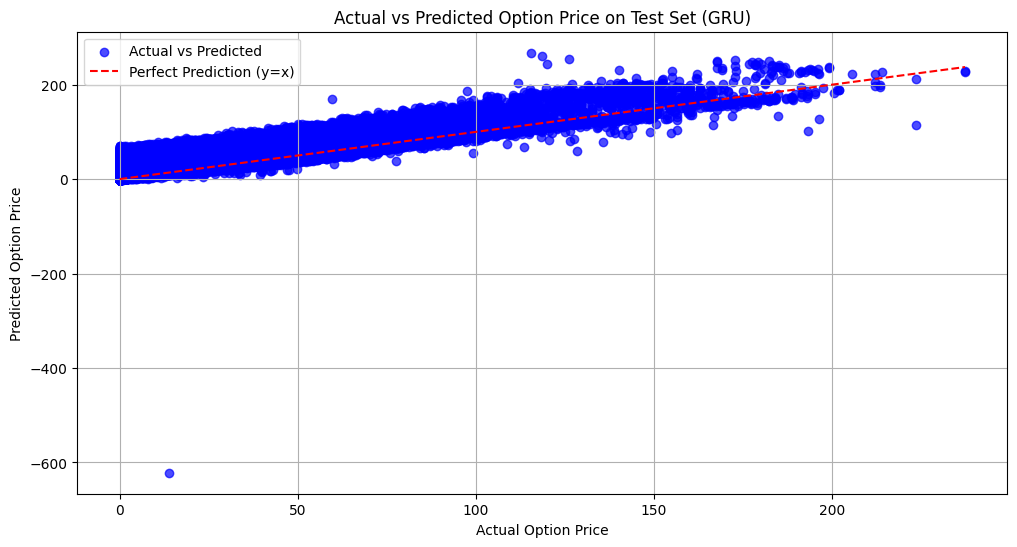

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Custom callback to track metrics
class MetricsCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, scaler_y):
        super(MetricsCallback, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scaler_y = scaler_y
        self.train_mse = []
        self.train_mae = []
        self.train_rmse = []
        self.val_mse = []
        self.val_mae = []
        self.val_rmse = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        y_val_pred = self.model.predict(self.X_val, verbose=0)

        y_train_true = self.scaler_y.inverse_transform(self.y_train)
        y_train_pred = self.scaler_y.inverse_transform(y_train_pred)
        y_val_true = self.scaler_y.inverse_transform(self.y_val)
        y_val_pred = self.scaler_y.inverse_transform(y_val_pred)

        train_mse = mean_squared_error(y_train_true, y_train_pred)
        train_mae = mean_absolute_error(y_train_true, y_train_pred)
        train_rmse = np.sqrt(train_mse)

        val_mse = mean_squared_error(y_val_true, y_val_pred)
        val_mae = mean_absolute_error(y_val_true, y_val_pred)
        val_rmse = np.sqrt(val_mse)

        self.train_mse.append(train_mse)
        self.train_mae.append(train_mae)
        self.train_rmse.append(train_rmse)
        self.val_mse.append(val_mse)
        self.val_mae.append(val_mae)
        self.val_rmse.append(val_rmse)

        print(f'Epoch {epoch+1}:')
        print(f'  Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}')
        print(f'  Val MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}')

# Build GRU model
model = Sequential()
model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(GRU(128, activation='relu', return_sequences=False))
model.add(Dense(1))

# Compile with MSE loss
model.compile(optimizer='adam', loss='mse')  # Using MSE as loss, since RMSE is sqrt(MSE)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
metrics_callback = MetricsCallback(X_train, y_train, X_val, y_val, scaler_y)

# Train model
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val), callbacks=[early_stop, metrics_callback], verbose=1)

# Evaluate on test set
y_pred = model.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

gru_mse_call = mean_squared_error(y_test_inv, y_pred_inv)
gru_mae_call = mean_absolute_error(y_test_inv, y_pred_inv)
gru_rmse_call = np.sqrt(gru_mse_call)

print(f'MSE on test set: {gru_mse_call:.4f}')
print(f'MAE on test set: {gru_mae_call:.4f}')
print(f'RMSE on test set: {gru_rmse_call:.4f}')


# Save model weights
model.save_weights('gru_call_price_model.weights.h5')

import matplotlib.pyplot as plt

# Plot training and validation metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1: Training and Validation Loss
axs[0, 0].plot(history.history['loss'], label='Train Loss')
axs[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Training and Validation Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss (MSE)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Subplot 2: MSE over Epochs
axs[0, 1].plot(metrics_callback.train_mse, label='Train MSE')
axs[0, 1].plot(metrics_callback.val_mse, label='Validation MSE')
axs[0, 1].set_title('Train and Validation MSE')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Subplot 3: MAE over Epochs
axs[1, 0].plot(metrics_callback.train_mae, label='Train MAE')
axs[1, 0].plot(metrics_callback.val_mae, label='Validation MAE')
axs[1, 0].set_title('Train and Validation MAE')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Subplot 4: RMSE over Epochs
axs[1, 1].plot(metrics_callback.train_rmse, label='Train RMSE')
axs[1, 1].plot(metrics_callback.val_rmse, label='Validation RMSE')
axs[1, 1].set_title('Train and Validation RMSE')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('RMSE')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()  # Display the 2x2 subplots

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.7, color='blue', label='Actual vs Predicted')
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--', label='Perfect Prediction (y=x)')
plt.title('Actual vs Predicted Option Price on Test Set (GRU)')
plt.xlabel('Actual Option Price')
plt.ylabel('Predicted Option Price')
plt.legend()
plt.grid(True)
plt.show()  # Display the scatter plot